In [1]:
import os
import datasets
from dataclasses import dataclass, field
from typing import Optional
import matplotlib.pyplot as plt
import requests
import random
import numpy as np
import torch
from datasets import load_dataset
from PIL import Image
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode
from pdb import set_trace

import transformers
from transformers import (
    VisionTextDualEncoderProcessor,
    VisionTextDualEncoderModel,
    AutoImageProcessor,
    AutoModel,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision')

# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.31.0.dev0")

/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "openai/clip-vit-base-patch32", "roberta-base"
)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

model.save_pretrained("clip-roberta")
processor.save_pretrained("clip-roberta")

/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[]

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor
from torch.optim import Adam
from torch.nn import functional as F
import torch

# Mapping from class ID to class name
class_names = {
    0: 'DUMPSTER', 1: 'VEHICLE', 2: 'SKID_STEER', 3: 'EXCAVATOR', 4: 'VAN',
    5: 'LUMBER_BUNDLE', 6: 'CONE', 7: 'TRUCK', 8: 'GARBAGE_CONTAINER',
    9: 'LADDER', 10: 'POWER_GENERATOR', 11: 'TELESCOPIC_HANDLER',
    12: 'CONCRETE_BUCKET', 13: 'BOOMLIFT', 14: 'PLYWOOD', 15: 'TOILET_CABIN',
    16: 'FORMWORK_PROP_BUNDLE', 17: 'CONDUIT_ROLL', 18: 'FORMWORK_PANEL',
    19: 'CONCRETE_COLUMN', 20: 'PLATE_COMPACTOR', 21: 'TROWEL_POWER',
    22: 'SLAB_SLEEVES', 23: 'MINI_EXCAVATOR', 24: 'CONTAINER', 25: 'SCISSORLIFT',
    26: 'PICKUP_TRUCK', 27: 'MOBILE_CRANE', 28: 'EQUIPMENT', 29: 'TIEBACK_RIG',
    30: 'TOWER_CRANE', 31: 'CONCRETE_PUMP', 32: 'DRILLRIG', 33: 'LOADER',
    34: 'OFFICE_TRAILER', 35: 'DOZER', 36: 'BUS', 37: 'ROLLER', 38: 'CONCRETE_RIDE',
    39: 'BACKHOE_LOADER', 40: 'FORKLIFT', 41: 'GRADER', 42: 'HAND_ROLLER',
    43: 'HOIST_CABIN', 44: "UNKNOWN"
}

def convert_to_words(text):
    words = text.split('_')
    lowercase_words = [word.lower() for word in words]
    return ' '.join(lowercase_words)

class CustomDataset(Dataset):
    def __init__(self, image_dir, text_dir):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        text_filename = os.path.splitext(image_filename)[0] + '.txt'
        text_path = os.path.join(self.text_dir, text_filename)

        # Load and parse annotations
        with open(text_path, 'r') as file:
            annotations = file.readlines()
        image = Image.open(image_path).convert("RGB")
        parsed_annotations = [list(map(float, line.strip().split())) for line in annotations]

        caption_indices = [44]
        if len(parsed_annotations) > 0:
            parsed_annotations.sort(key=lambda x: x[3] * x[4], reverse=True)
            top_annotations = parsed_annotations[:5]
            caption_indices = [int(ann[0]) for ann in top_annotations]
        
        captions = [convert_to_words(class_names[idx]) for idx in caption_indices]    
        caption = ' '.join(captions)
        return {
            "image": image,
            "captions": caption
        }

    
def collate_fn(batch):
  batch = list(filter(lambda x: x is not None, batch))
  return torch.utils.data.dataloader.default_collate(batch)

In [4]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train'
text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/train'

dataset = CustomDataset(image_dir=image_dir, text_dir=text_dir)
train_dataloader = DataLoader(dataset,batch_size=32, collate_fn=collate_fn)


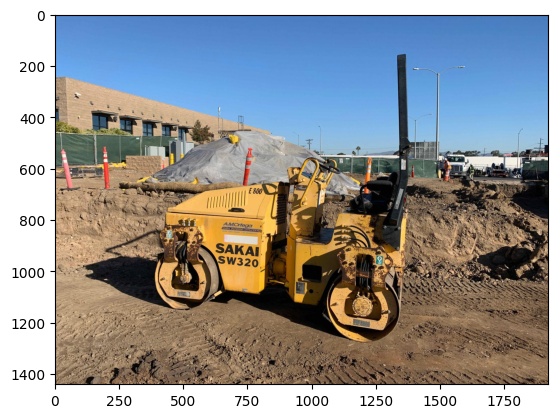

In [5]:
plt.imshow(dataset[100]["image"])

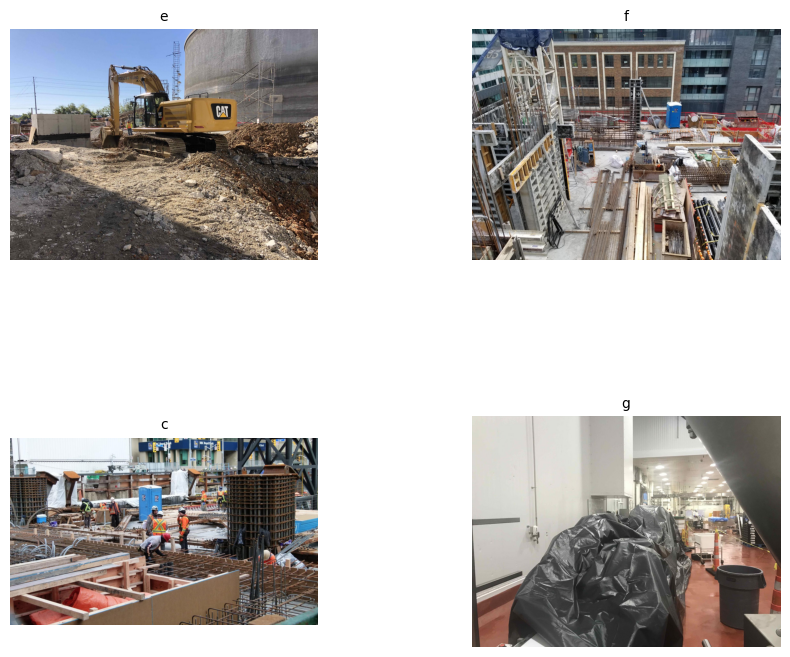

In [6]:
def show_images(dset, num_images=8, without_caption=True,num_columns=2,img_size=(4, 4)):
    num_rows = -(-num_images // num_columns)  # Ceiling division
    fig = plt.figure(figsize=(img_size[0] * num_columns, img_size[1] * num_rows))

    _list = list(range(len(dset)))
    for i in range(num_images):
        index = _list[i]
        ax = fig.add_subplot(num_rows, num_columns, i+1)
        image = dset[index]['image']
        plt.imshow(image)
        
        # Set title as the first caption
        if without_caption:
            caption = dset[index]['captions'][0]
            ax.set_title(caption, fontsize=10)
        
        # Remove axis
        plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.01)  # Adjust these values as needed

    plt.show()
show_images(dataset, num_images=4, without_caption=True)

In [7]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"},
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    image_processor_name: str = field(default=None, metadata={"help": "Name or path of preprocessor config."})
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": (
                "Will use the token generated when running `huggingface-cli login` (necessary to use this script "
                "with private models)."
            )
        },
    )
        
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """
    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    data_dir: Optional[str] = field(default=None, metadata={"help": "The data directory containing input files."})
    image_column: Optional[str] = field(
        default="image_path",
        metadata={"help": "The name of the column in the datasets containing the full image file paths."},
    )
    caption_column: Optional[str] = field(
        default="caption",
        metadata={"help": "The name of the column in the datasets containing the image captions."},
    )
    max_seq_length: Optional[int] = field(
        default=128,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. Sequences longer "
                "than this will be truncated, sequences shorter will be padded."
            )
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
args_dict = {'output_dir': './clip-roberta-finetuned',
 'model_name_or_path': './clip-roberta',
 'data_dir': './data',
 'dataset_name': 'arampacha/rsicd',
 'image_column': 'image',
 'caption_column': 'captions',
 'remove_unused_columns': False,
 'per_device_train_batch_size': 64,
 'per_device_eval_batch_size': 64,
 'learning_rate': 5e-05,
 'warmup_steps': 0,
 'weight_decay': 0.1,
 'overwrite_output_dir': True,
 'push_to_hub': False}

parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_dict(args_dict)

# Dataset
class Transform(torch.nn.Module):
    def __init__(self, image_size, mean, std):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size], interpolation=InterpolationMode.BICUBIC, antialias=True),
            CenterCrop(image_size),
            ConvertImageDtype(torch.float),
            Normalize(mean, std),
        )
    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x
    
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path, cache_dir=model_args.cache_dir, use_fast=model_args.use_fast_tokenizer
)

image_processor = AutoImageProcessor.from_pretrained(
    model_args.image_processor_name or model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

model = AutoModel.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

config = model.config
set_seed(training_args.seed)
image_transformations = Transform(
    config.vision_config.image_size, image_processor.image_mean, image_processor.image_std
)
#image_transformations = torch.jit.script(image_transformations)
def tokenize_captions(examples):
    captions = [example[0] for example in examples[data_args.caption_column]]
    text_inputs = tokenizer(captions, max_length=data_args.max_seq_length, padding="max_length", truncation=True)
    examples["input_ids"] = text_inputs.input_ids
    examples["attention_mask"] = text_inputs.attention_mask
    return examples

def transform_images(examples):
    images = [torch.tensor(np.array(image)).permute(2, 0, 1) for image in examples[data_args.image_column]]
    examples["pixel_values"] = images
    return examples

train_image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train'
train_text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/train'
eval_image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val'
eval_text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/val'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Function to load and preprocess the dataset
def load_and_preprocess_dataset(image_dir, text_dir):
    data = []
    for image_filename in os.listdir(image_dir):
        if image_filename.endswith('.jpg') or image_filename.endswith('.jpeg'):
            image_path = os.path.join(image_dir, image_filename)
            text_filename = os.path.splitext(image_filename)[0] + '.txt'
            text_path = os.path.join(text_dir, text_filename)

            # Load and parse annotations
            with open(text_path, 'r') as file:
                annotations = file.readlines()
            image = Image.open(image_path).convert("RGB")
            image = transform(image)
            parsed_annotations = [list(map(float, line.strip().split())) for line in annotations]

            caption_indices = [44]
            if len(parsed_annotations) > 0:
                parsed_annotations.sort(key=lambda x: x[3] * x[4], reverse=True)
                top_annotations = parsed_annotations[:5]
                caption_indices = [int(ann[0]) for ann in top_annotations]

            captions = [convert_to_words(class_names[idx]) for idx in caption_indices]    
            caption = ' '.join(captions)
            data.append({"image": image, "captions": caption})

    return data

train_data = load_and_preprocess_dataset(train_image_dir, train_text_dir)
train_dataset = datasets.Dataset.from_dict({"image": [item["image"] for item in train_data], "captions": [item["captions"] for item in train_data]})

eval_data = load_and_preprocess_dataset(eval_image_dir, eval_text_dir)
eval_dataset = datasets.Dataset.from_dict({"image": [item["image"] for item in eval_data], "captions": [item["captions"] for item in eval_data]})

train_dataset = train_dataset.map(
    function=tokenize_captions,
    batched=True,
    num_proc=data_args.preprocessing_num_workers,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on train dataset",
)
train_dataset.set_transform(transform_images)

eval_dataset = eval_dataset.map(
    function=tokenize_captions,
    batched=True,
    num_proc=data_args.preprocessing_num_workers,
    load_from_cache_file=not data_args.overwrite_cache,
    desc="Running tokenizer on train dataset",
)
eval_dataset.set_transform(transform_images)

In [ ]:
train_dataset[0]

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
)

# 9. Training
train_result = trainer.train()
trainer.log_metrics("train", train_result.metrics)
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)


KeyError: 'pixel_values'